# Configuring the trend in Kriging


The goal of this example is to show how to configure the trend in a Kriging metamodel. This is why this example focuses on the three available trends:
* `ConstantBasisFactory`,
* `LinearBasisFactory`,
* `QuadraticBasisFactory`.

For this purpose, we use the cantilever beam example.

## Definition of the model

In [1]:
import openturns as ot
ot.RandomGenerator.SetSeed(0)

We define the symbolic function which evaluates the output Y depending on the inputs E, F, L and I.

In [2]:
model = ot.SymbolicFunction(["E", "F", "L", "I"], ["F*L^3/(3*E*I)"])

Then we define the distribution of the input random vector. 

In [3]:
# Young's modulus E
E = ot.Beta(0.9, 3.5, 2.5e7, 5.0e7) # in N/m^2
E.setDescription("E")
# Load F
F = ot.LogNormal() # in N
F.setParameter(ot.LogNormalMuSigma()([30.e3, 9e3, 15.e3]))
F.setDescription("F")
# Length L
L = ot.Uniform(250., 260.) # in cm
L.setDescription("L")
# Moment of inertia I
I = ot.Beta(2.5, 4, 310, 450) # in cm^4
I.setDescription("I")

Finally, we define the dependency using a `NormalCopula`.

In [4]:
dim = 4 # number of inputs
R = ot.CorrelationMatrix(dim)
R[2, 3] = -0.2 
myCopula = ot.NormalCopula(ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(R))
myDistribution = ot.ComposedDistribution([E, F, L, I], myCopula)

## Create the design of experiments

We consider a simple Monte-Carlo sampling as a design of experiments. This is why we generate an input sample using the `getSample` method of the distribution. Then we evaluate the output using the `model` function.

In [5]:
sampleSize_train = 20
X_train = myDistribution.getSample(sampleSize_train)
Y_train = model(X_train)

## Create the metamodel

In order to create the kriging metamodel, we first select a constant trend with the `ConstantBasisFactory` class. Then we use a squared exponential covariance model. Finally, we use the `KrigingAlgorithm` class to create the kriging metamodel, taking the training sample, the covariance model and the trend basis as input arguments. 

In [6]:
dimension = myDistribution.getDimension()
covarianceModel = ot.SquaredExponential([1.]*dimension, [1.0])

In [7]:
basis = ot.ConstantBasisFactory(dimension).build()
algo = ot.KrigingAlgorithm(X_train, Y_train, covarianceModel, basis)
algo.run()
result = algo.getResult()
krigingWithConstantTrend = result.getMetaModel()

The `getTrendCoefficients` method returns the coefficients of the trend.

In [8]:
result.getTrendCoefficients()

[class=Point name=Unnamed dimension=1 values=[21.4543]]

The constant trend always has only one coefficient (if there is one single output).

In [9]:
result.getCovarianceModel()

class=SquaredExponential scale=class=Point name=Unnamed dimension=4 values=[6.26788,5.38598,7.19611,6.89181] amplitude=class=Point name=Unnamed dimension=1 values=[9.22369]

The `SquaredExponential` model has one amplitude coefficient and 4 scale coefficients. This is because this covariance model is anisotropic : each of the 4 input variables is associated with its own scale coefficient. 

## Setting the trend

In [10]:
basis = ot.LinearBasisFactory(dimension).build()
algo = ot.KrigingAlgorithm(X_train, Y_train, covarianceModel, basis)
algo.run()
result = algo.getResult()
krigingWithLinearTrend = result.getMetaModel()
result.getTrendCoefficients()

[class=Point name=Unnamed dimension=5 values=[14.8272,-2.01417,3.45966,0.410961,-0.887691]]

The number of coefficients in the linear and quadratic trends depends on the number of inputs, which is 
$$
dim = 4
$$

in the cantilever beam case.

We observe that the number of coefficients in the trend is 5, which corresponds to:
* 1 coefficient for the constant part,
* dim=4 coefficients for the linear part.

In [11]:
basis = ot.QuadraticBasisFactory(dimension).build()
algo = ot.KrigingAlgorithm(X_train, Y_train, covarianceModel, basis)
algo.run()
result = algo.getResult()
krigingWithQuadraticTrend = result.getMetaModel()
result.getTrendCoefficients()

[class=Point name=Unnamed dimension=15 values=[13.3454,-2.15509,3.69566,0.337431,-0.91664,0.547578,-0.558795,-0.0973574,0.0538881,-0.053952,0.11991,-0.224006,0.0960829,-0.0669981,0.168978]]

This time, the trend has 15 coefficients:
* 1 coefficient for the constant part,
* 4 coefficients for the linear part,
* 10 coefficients for the quadratic part.

This is because the number of coefficients in the quadratic part has  
$$
\frac{dim (dim+1)}{2}=\frac{4\times 5}{2}=10
$$

coefficients, associated with the symmetric matrix of the quadratic function. 

## Validate the metamodel

We finally want to validate the kriging metamodel. This is why we generate a validation sample which size is equal to 100 and we evaluate the output of the model on this sample.

In [12]:
sampleSize_test = 100
X_test = myDistribution.getSample(sampleSize_test)
Y_test = model(X_test)

In [13]:
def drawMetaModelValidation(X_test, Y_test, krigingMetamodel, title):
    val = ot.MetaModelValidation(X_test, Y_test, krigingMetamodel)
    Q2 = val.computePredictivityFactor()
    graph = val.drawValidation()
    graph.setLegends([""])
    graph.setLegends(["%s, Q2 = %.2f%%" % (title, 100*Q2),""])
    graph.setLegendPosition("topleft")
    return graph

In [14]:
import pylab as pl
from openturns.viewer import View

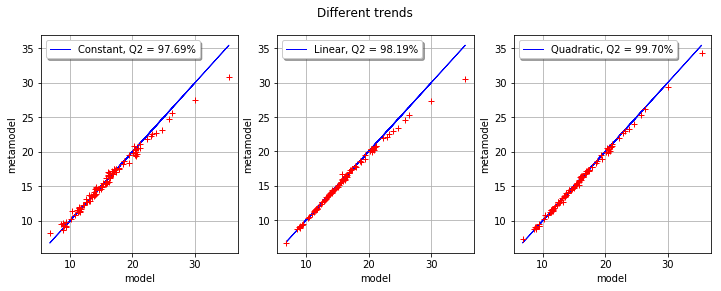

In [15]:
fig = pl.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 3, 1)
graphConstant = drawMetaModelValidation(X_test, Y_test, krigingWithConstantTrend, "Constant")
_ = View(graphConstant, figure=fig, axes=[ax1])
ax2 = fig.add_subplot(1, 3, 2)
graphLinear = drawMetaModelValidation(X_test, Y_test, krigingWithLinearTrend, "Linear")
_ = View(graphLinear, figure=fig, axes=[ax2])
ax3 = fig.add_subplot(1, 3, 3)
graphQuadratic = drawMetaModelValidation(X_test, Y_test, krigingWithQuadraticTrend, "Quadratic")
_ = View(graphQuadratic, figure=fig, axes=[ax3])
_ = fig.suptitle("Different trends")

We observe that the three trends perform very well in this case. More precisely, the quadratic trend has better Q2 than the linear trend, which has a better Q2 than the constant trend. Indeed, the more the trend has coefficients, the more the kriging metamodel has flexibility to adjust to the training sample. This does not mean, however, that the trend coefficients will provide a good fit for the validation sample. 

The number of parameters in each kriging metamodel is the following:
* the constant trend kriging has 6 coefficients to estimate: 5 coefficients for the covariance matrix and 1 coefficient for the trend,
* the linear trend kriging has 10 coefficients to estimate: 5 coefficients for the covariance matrix and 5 coefficients for the trend,
* the quadratic trend kriging has 20 coefficients to estimate: 5 coefficients for the covariance matrix and 15 coefficients for the trend.

In the cantilever beam example, fitting the metamodel with a training sample which size is only equal to 20 is made much easier because the function to approximate is almost linear. 